In [1]:
import time

start = time.time()


end = time.time()
print(end - start)

0.0


In [2]:
import pandas as pd
import numpy as np
import sqlite3
import json

from PIL import Image


from matplotlib.path import Path

import matplotlib.pyplot as plt

In [3]:
image_id = '817255772895577'
image_path = f"c:\\temp\\mapillary_{image_id}.jpg"
image_path

'c:\\temp\\mapillary_817255772895577.jpg'

In [4]:
def load_image(load_from='local', service=None, path=None):
    if (load_from == 'local') & (path is None):
        print('load_from local but no path supplied, will try to load from service')
    elif (load_from == 'local') & (path is not None):
        try:
            image = Image.open(path)
        except:
            print("excep")

    return image


#image = load_image(path="c:\\temp\\mapillary_817255772895577.jpg")
image = load_image(path=f"c:\\temp\\mapillary_{image_id}.jpg")



In [5]:
#save outcomes
# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('c://temp//green_repository2.db')

df_image_metadata = pd.read_sql('select * from image_metadata', conn)
df_detections = pd.read_sql('SELECT * FROM image_detection_coords', conn)


#df['properties'] = df['properties'].apply(json.loads)
#df['coordinates'] = df['coordinates'].apply(json.loads)

df_image_metadata = df_image_metadata.map(json.loads)
df_detections = df_detections.map(json.loads)

#df_detections['properties'] = df_detections['properties'].apply(json.loads)
#df_detections['coordinates'] = df_detections['coordinates'].apply(json.loads)

# Close the connection
conn.close()



In [6]:
df_detections = pd.merge(df_image_metadata,df_detections, left_on='image_id', right_on='image_id')

In [7]:
df_detections.head(1)

image_source         image_id  captured_at_unix        lat      long  \
0    mapillary  817255772895577     1664012504800  98.686175  3.609915   

   original_height  original_width  height  width  \
0             2160            3840    2160   3840   

                                  image_path_on_disk     detection_id  \
0  c:\temp\mapillary_817255772895577_thumb_origin...  817376652883489   

                detection_label  feature_id  extent properties  \
0  construction--barrier--fence           1    4096         {}   

                                         coordinates  
0  [[197, 1009], [203, 1004], [228, 1000], [230, ...

In [99]:
list(set(df_detections['detection_label']))


['void--unlabeled',
 'human--rider--motorcyclist',
 'construction--structure--building',
 'void--ego-vehicle',
 'human--person--individual',
 'object--vehicle--other-vehicle',
 'object--vehicle--car',
 'construction--flat--sidewalk',
 'nature--vegetation',
 'void--ground',
 'construction--barrier--fence',
 'construction--flat--road',
 'object--wire-group',
 'object--vehicle--motorcycle',
 'void--dynamic',
 'object--support--utility-pole',
 'object--street-light',
 'object--sign--advertisement',
 'construction--barrier--wall',
 'object--banner',
 'nature--sky',
 'object--vehicle--bus',
 'object--sign--store']

In [110]:
df_sample = df_detections.sample()
df_sample = df_detections[df_detections['detection_label'] == 'nature--sky'] #'nature--vegetation']
df_sample.shape


(27, 19)

## Get Percent of Image by Class

In [101]:
# get pixel size of image
# for each class, create a mask and count the number of 1s
# store and divide by total image size

target_image = image_id

classes = list(set(df_detections['detection_label'].tolist()))
classes

def create_image_mask(image_height, image_width, polygon, value=1):
    
    mask = np.zeros((image_height, image_width), dtype=np.uint8)


    y, x = np.mgrid[:mask.shape[0], :mask.shape[1]]
    points = np.vstack((x.ravel(), y.ravel())).T
    path = Path(polygon)
    mask[path.contains_points(points).reshape(mask.shape)] = value

    return mask


mask = create_image_mask(1152, 2048, df_sample['coordinates'].tolist()[3], 1)
mask.sum()


902

In [102]:
df_detections['image_mask'] = df_detections.apply(lambda x: create_image_mask(x.height, x.width, x.coordinates), axis=1)


In [103]:
import numpy as np
from shapely.geometry import Polygon
import matplotlib.path as mplPath



def detect_pixel_count(coords):

    polygon = Polygon(coords)
    
    # Step 2: Create a grid of points covering the bounding box of the polygon
    min_x, min_y, max_x, max_y = polygon.bounds
    x = np.arange(min_x, max_x + 1)
    y = np.arange(min_y, max_y + 1)
    xx, yy = np.meshgrid(x, y)
    points = np.c_[xx.ravel(), yy.ravel()]
    
    # Step 3: Check which points lie within the polygon
    path = mplPath.Path(coords)
    mask = path.contains_points(points)
    
    # Step 4: Count the number of pixels (points) within the polygon
    num_pixels_within_polygon = np.sum(mask)
    
    print(f'Number of pixels within the polygon: {num_pixels_within_polygon}')


detect_pixel_count(df_detections['coordinates'].loc[72])

#.apply(lambda x: detect_pixel_count(x.coordinates))
 


Number of pixels within the polygon: 592279


In [104]:
df_detections['detection_pixel_count'] = df_detections['image_mask'].apply(lambda x: x.sum())
df_detections['detection_prct_of_image'] = df_detections.apply(lambda x: x.detection_pixel_count / (x.height * x.width), axis=1)

In [105]:
df_detections.sort_values(by="detection_pixel_count", ascending=False)

image_source         image_id  captured_at_unix        lat      long  \
72     mapillary  817255772895577     1664012504800  98.686175  3.609915   
88     mapillary  817255772895577     1664012504800  98.686175  3.609915   
27     mapillary  817255772895577     1664012504800  98.686175  3.609915   
119    mapillary  817255772895577     1664012504800  98.686175  3.609915   
11     mapillary  817255772895577     1664012504800  98.686175  3.609915   
..           ...              ...               ...        ...       ...   
113    mapillary  817255772895577     1664012504800  98.686175  3.609915   
87     mapillary  817255772895577     1664012504800  98.686175  3.609915   
44     mapillary  817255772895577     1664012504800  98.686175  3.609915   
117    mapillary  817255772895577     1664012504800  98.686175  3.609915   
174    mapillary  817255772895577     1664012504800  98.686175  3.609915   

     original_height  original_width  height  width  \
72              2160            3840    1152   2048   
88              2160            3840    1152   2048   
27              2160            3840    1152   2048   
119             2160            3840    1152   2048   
11              2160            3840    1152   2048   
..               ...             ...     ...    ...   
113             2160            3840    1152   2048   
87              2160            3840    1152   2048   
44              2160            3840    1152   2048   
117             2160            3840    1152   2048   
174             2160            3840    1152   2048   

                        image_path_on_disk     detection_id  \
72   c:\temp\mapillary_817255772895577.jpg  817376856216802   
88   c:\temp\mapillary_817255772895577.jpg  817376902883464   
27   c:\temp\mapillary_817255772895577.jpg  817376739550147   
119  c:\temp\mapillary_817255772895577.jpg  817376989550122   
11   c:\temp\mapillary_817255772895577.jpg  817376686216819   
..                                     ...              ...   
113  c:\temp\mapillary_817255772895577.jpg  817376969550124   
87   c:\temp\mapillary_817255772895577.jpg  817376899550131   
44   c:\temp\mapillary_817255772895577.jpg  817376776216810   
117  c:\temp\mapillary_817255772895577.jpg  817376982883456   
174  c:\temp\mapillary_817255772895577.jpg  817377142883440   

                       detection_label  feature_id  extent properties  \
72                         nature--sky           1    4096         {}   
88                  nature--vegetation           1    4096         {}   
27   construction--structure--building           1    4096         {}   
119                 object--wire-group           1    4096         {}   
11            construction--flat--road           1    4096         {}   
..                                 ...         ...     ...        ...   
113                 object--wire-group           1    4096         {}   
87                  nature--vegetation           1    4096         {}   
44                         nature--sky           1    4096         {}   
117                 object--wire-group           1    4096         {}   
174                    void--unlabeled           1    4096         {}   

                                           coordinates  \
72   [[599, 1152], [1864, 1152], [1864, 1148], [186...   
88   [[0, 1152], [599, 1152], [600, 1141], [592, 11...   
27   [[1180, 410], [1180, 431], [1189, 433], [1189,...   
119  [[1355, 546], [1356, 550], [1362, 551], [1364,...   
11   [[1011, 34], [1014, 41], [1009, 60], [1012, 64...   
..                                                 ...   
113  [[1271, 533], [1272, 533], [1272, 532], [1271,...   
87   [[1557, 632], [1558, 632], [1558, 631], [1558,...   
44   [[1351, 544], [1352, 544], [1352, 543], [1351,...   
117  [[2027, 1000], [2028, 1000], [2028, 999], [202...   
174  [[1563, 255], [1564, 255], [1563, 253], [1563,...   

                                            image_mask  detection_pixel_count  \
72   [[0, 0, 0, 0,

In [106]:
summary = df_detections[['detection_label','detection_pixel_count']].groupby('detection_label').sum().sort_values(by='detection_pixel_count', ascending=False)
summary['prct'] = summary['detection_pixel_count'].apply(lambda x: (x / summary['detection_pixel_count'].sum() * 100))
summary

detection_pixel_count       prct
detection_label                                                    
nature--sky                                       654613  27.610573
nature--vegetation                                488520  20.605025
construction--structure--building                 276963  11.681875
construction--flat--road                          237263  10.007390
object--wire-group                                178267   7.519029
object--vehicle--other-vehicle                    102401   4.319117
void--ego-vehicle                                  96050   4.051242
void--unlabeled                                    76445   3.224333
object--vehicle--car                               62611   2.640836
construction--barrier--wall                        41009   1.729697
void--dynamic                                      31017   1.308250
human--rider--motorcyclist                         25770   1.086939
construction--barrier--fence                       19410   0.818684
void--ground                                       17283   0.728970
construction--flat--sidewalk                       17120   0.722095
object--vehicle--motorcycle                        16676   0.703368
object--support--utility-pole                      13497   0.569283
object--sign--store                                 7830   0.330257
object--banner                                      4082   0.172173
object--sign--advertisement                         2664   0.112363
object--vehicle--bus                                 924   0.038973
human--person--individual                            332   0.014003
object--street-light                                 131   0.005525

# Draw a map

In [8]:
def draw_polygon(polygon, max_size=3000):
    #print(detection_geometry['mpy-or']['geometry']['coordinates'])
    normalized_polygon = []
    w = []
    y = []
    for xy in polygon:

        w.append(xy[0])
        y.append(xy[1])

    fig, ax = plt.subplots(figsize=(8, 8))  # 8x8 inches
    ax.plot(w, y, marker='o', markersize=2) 

    # Set the x and y limits to be consistent
    #max_value = 3000  # Example maximum value
    ax.set_xlim(0, max_size)
    ax.set_ylim(0, max_size)
    
    # Force the two axes to intersect at 0
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    # Adding title and labels
    plt.title('Path Plot of w and y Coordinates')
    plt.xlabel('w')
    plt.ylabel('y')
    
    # Display the plot
    plt.show()

    return normalized_polygon
    

(27, 16)

In [17]:
#draw_polygon(df_sample['coordinates'].tolist()[3], max_size=3000)

In [111]:
def draw_polygons(polygons, max_size=3000, color='green'):
    #print(detection_geometry['mpy-or']['geometry']['coordinates'])
    normalized_polygon = []

    polygons_for_chart = []
    for polygon in polygons:
        w = []
        y = []
        for xy in polygon:

            w.append(xy[0])
            y.append(xy[1])
        polygons_for_chart.append([w,y])




    #plt.plot(w, y, marker='o')  # marker='o' adds markers to the points

    fig, ax = plt.subplots(figsize=(8, 8))  # 8x8 inches
    for shape in polygons_for_chart:
        #ax.plot(shape[0], shape[1], marker='o', markersize=2, color=color)
        ax.fill(shape[0], shape[1], color=color)      


    #ax.plot(w, y, marker='o', markersize=2) 
    #ax.plot([10,100,100,10], [100,100,10,10], marker='o', markersize=2) 

    # Set the x and y limits to be consistent
    #max_value = 3000  # Example maximum value
    ax.set_xlim(0, max_size)
    ax.set_ylim(0, max_size)
    
    # Force the two axes to intersect at 0
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    # Adding title and labels
    plt.title('Path Plot of w and y Coordinates')
    plt.xlabel('w')
    plt.ylabel('y')
    
    # Display the plot
    plt.show()

    return normalized_polygon

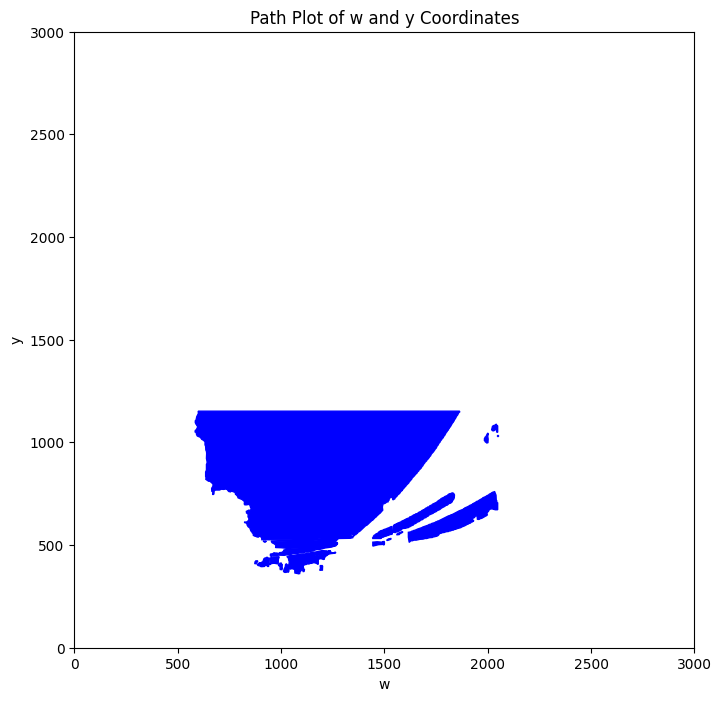

[]

In [113]:
draw_polygons(df_sample['coordinates'].tolist(), max_size=3000, color='blue')

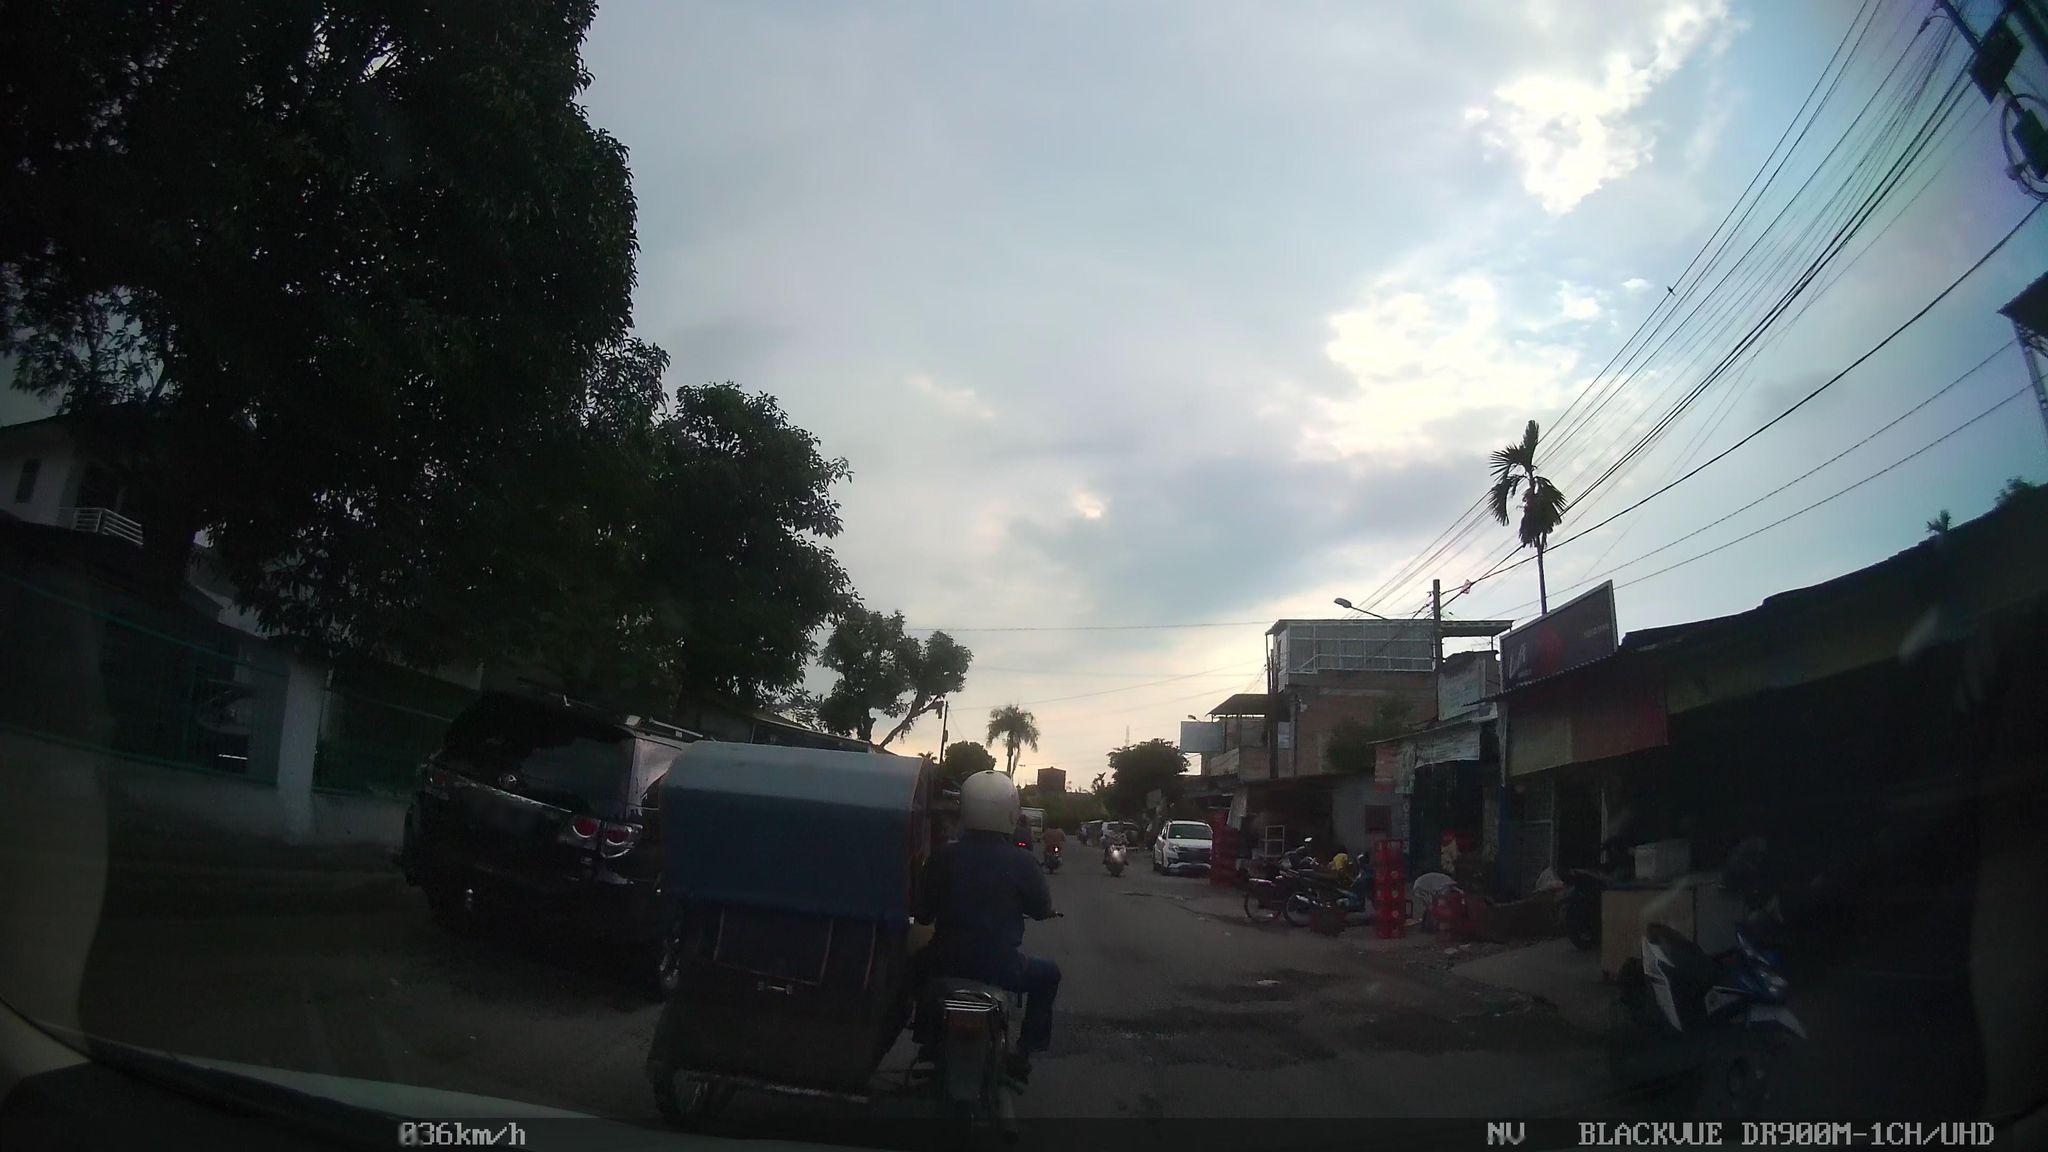

In [109]:
image

In [75]:
from collections import Counter
x = Counter(df['detection_id'].tolist())
x.most_common(4)

[('817377512883403', 9),
 ('817377566216731', 9),
 ('817376739550147', 6),
 ('817376989550122', 6)]

28    construction--structure--building
Name: detection_label, dtype: object


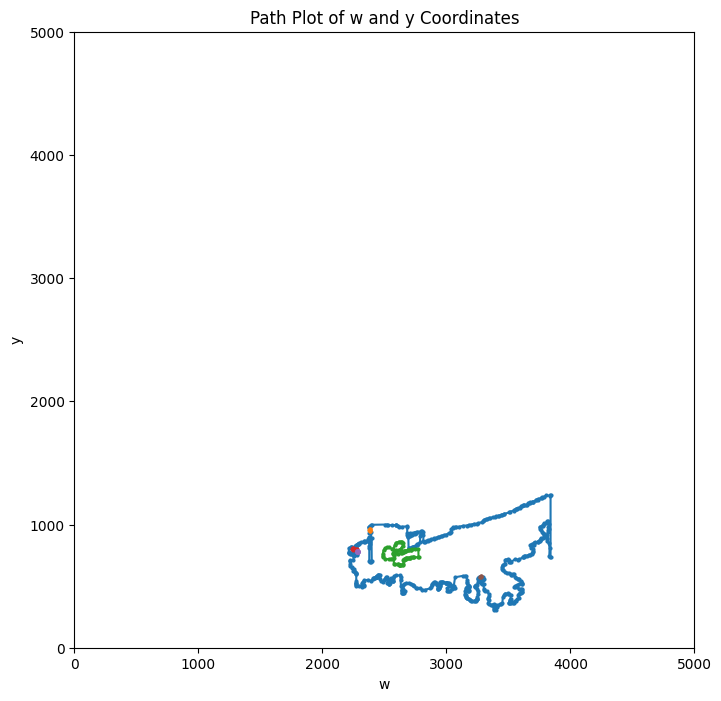

[]

In [85]:
df_sample = df[df['detection_id'] == '817376739550147']
print(df_sample['detection_label'].sample())
draw_polygons(df_sample['coordinates'].tolist(), max_size=5000)

In [73]:
df_sample

image_source         image_id  captured_at_unix        lat      long  \
308    mapillary  817255772895577     1664012504800  98.686175  3.609915   
309    mapillary  817255772895577     1664012504800  98.686175  3.609915   
310    mapillary  817255772895577     1664012504800  98.686175  3.609915   
312    mapillary  817255772895577     1664012504800  98.686175  3.609915   
319    mapillary  817255772895577     1664012504800  98.686175  3.609915   

     height  width                     image_path_on_disk     detection_id  \
308    2160   3840  c:\temp\mapillary_817255772895577.jpg  817377532883401   
309    2160   3840  c:\temp\mapillary_817255772895577.jpg  817377536216734   
310    2160   3840  c:\temp\mapillary_817255772895577.jpg  817377536216734   
312    2160   3840  c:\temp\mapillary_817255772895577.jpg  817377542883400   
319    2160   3840  c:\temp\mapillary_817255772895577.jpg  817377562883398   

                detection_label  feature_id  extent properties  \
308  human--rider--motorcyclist           1    4096         {}   
309  human--rider--motorcyclist           1    4096         {}   
310  human--rider--motorcyclist           2    4096         {}   
312  human--rider--motorcyclist           1    4096         {}   
319  human--rider--motorcyclist           1    4096         {}   

                                           coordinates  
308  [[1954, 593], [1956, 596], [1956, 599], [1958,...  
309  [[2070, 541], [2073, 589], [2079, 593], [2081,...  
310  [[2110, 562], [2112, 558], [2115, 547], [2114,...  
312  [[1712, 236], [1710, 247], [1698, 266], [1705,...  
319  [[1903, 591], [1912, 616], [1912, 631], [1920,...

In [72]:
def draw_polygons_from_df(df, max_size=3000):
    polygons = row.coordinates
    #print(detection_geometry['mpy-or']['geometry']['coordinates'])
    normalized_polygon = []

    polygons_for_chart = []
    for polygon in polygons:
        w = []
        y = []
        for xy in polygon:

            w.append(xy[0])
            y.append(xy[1])
        polygons_for_chart.append([w,y])




    #plt.plot(w, y, marker='o')  # marker='o' adds markers to the points

    fig, ax = plt.subplots(figsize=(8, 8))  # 8x8 inches
    for shape in polygons_for_chart:
        ax.plot(shape[0], shape[1], marker='o', markersize=2) 
    #ax.plot(w, y, marker='o', markersize=2) 
    #ax.plot([10,100,100,10], [100,100,10,10], marker='o', markersize=2) 

    # Set the x and y limits to be consistent
    #max_value = 3000  # Example maximum value
    ax.set_xlim(0, max_size)
    ax.set_ylim(0, max_size)
    
    # Force the two axes to intersect at 0
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

    # Adding title and labels
    plt.title('Path Plot of w and y Coordinates')
    plt.xlabel('w')
    plt.ylabel('y')
    
    # Display the plot
    plt.show()

    return normalized_polygon


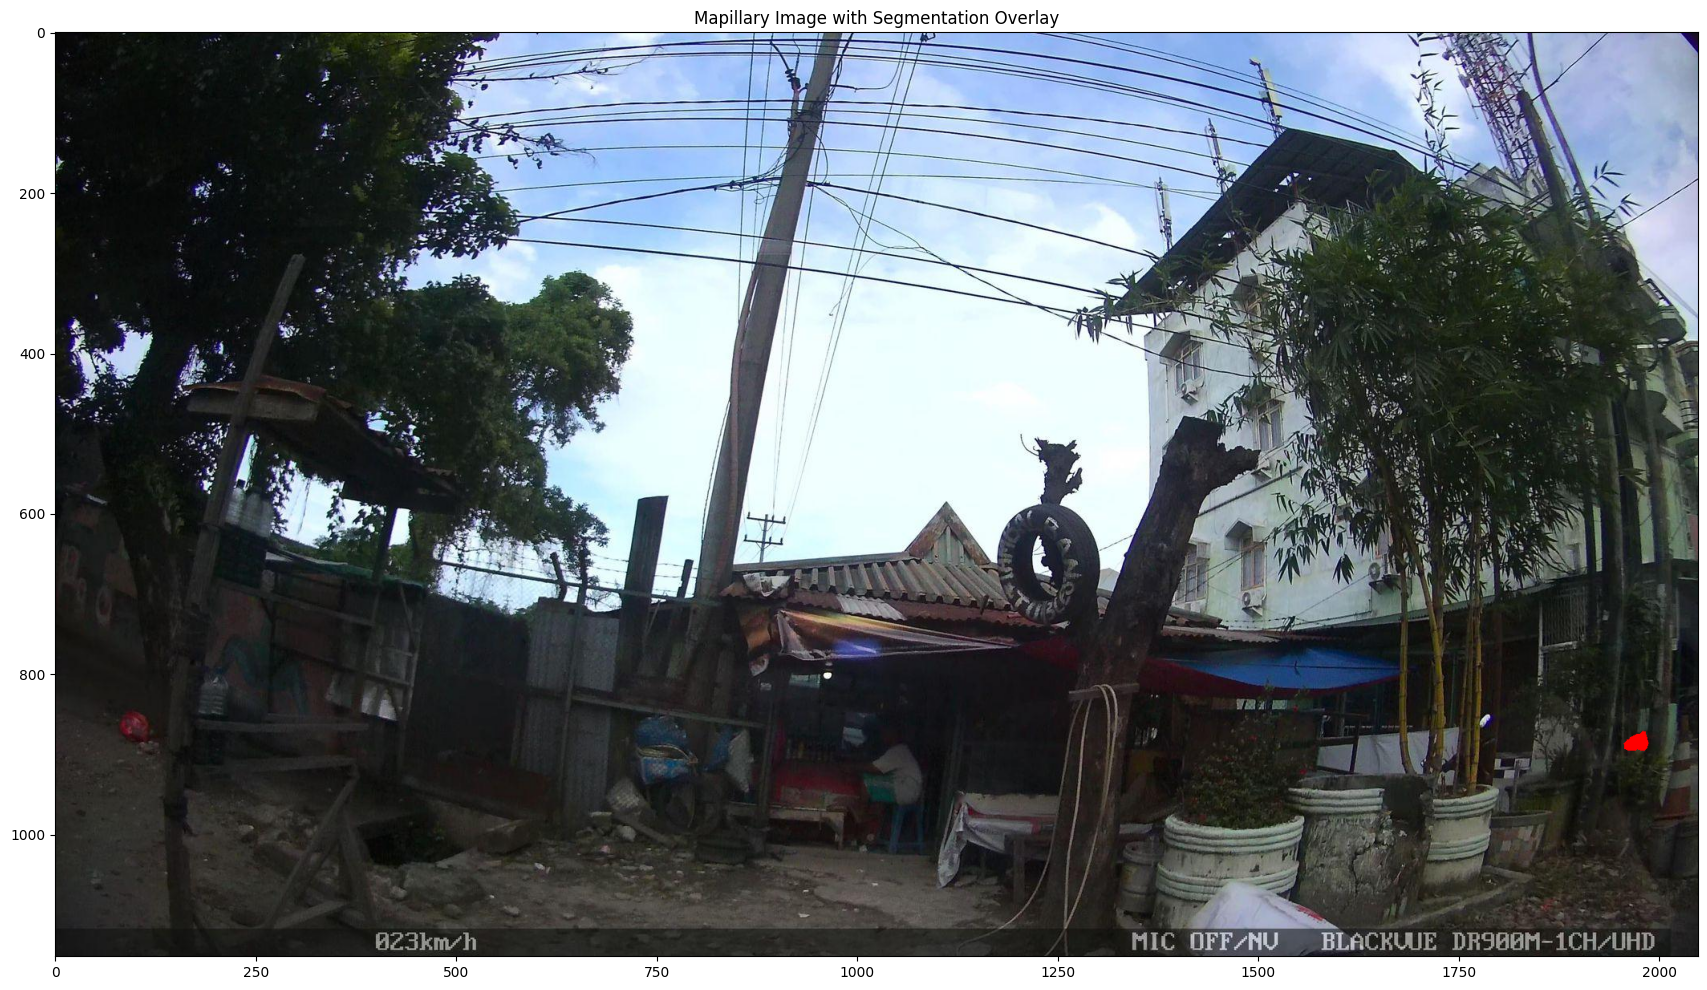

In [92]:
# Initialize an empty mask
mask = np.zeros((image.height, image.width), dtype=np.uint8)

def create_mask(mask, polygon, value):
    y, x = np.mgrid[:mask.shape[0], :mask.shape[1]]
    points = np.vstack((x.ravel(), y.ravel())).T
    path = Path(polygon)
    mask[path.contains_points(points).reshape(mask.shape)] = value




#x_poly = [[100,100],[500,100],[500,500],[100,500]]
#draw_polygons(mask, normalized_polygon, 1)
create_mask(mask, df_sample['coordinates'].tolist()[3], 1)

#reverse the mask on the horizontal dimension
mask = mask[::-1]


# Step 4: Overlay the mask on the image
masked_image = np.array(image)
masked_image[mask == 1] = [255, 0, 0]  # Color roads in red
masked_image[mask == 2] = [0, 0, 255]  # Color buildings in blue

# Step 5: Visualize the result
plt.figure(figsize=(24, 12))
plt.imshow(masked_image)
plt.title('Mapillary Image with Segmentation Overlay')
plt.show()

In [6]:
df_detections

image_id     detection_id                detection_label  \
0    817255772895577  817376652883489   construction--barrier--fence   
1    817255772895577  817376656216822   construction--barrier--fence   
2    817255772895577  817376659550155   construction--barrier--fence   
3    817255772895577  817376662883488   construction--barrier--fence   
4    817255772895577  817376666216821       construction--flat--road   
..               ...              ...                            ...   
331  817255772895577  817377576216730                 object--banner   
332  817255772895577  817377579550063  object--support--utility-pole   
333  817255772895577  817377582883396           object--vehicle--bus   
334  817255772895577  817377582883396           object--vehicle--bus   
335  817255772895577  817377586216729      human--person--individual   

     feature_id  extent properties  \
0             1    4096         {}   
1             1    4096         {}   
2             1    4096         {}   
3             1    4096         {}   
4             1    4096         {}   
..          ...     ...        ...   
331           1    4096         {}   
332           1    4096         {}   
333           1    4096         {}   
334           2    4096         {}   
335           1    4096         {}   

                                           coordinates  
0    [[197, 1009], [203, 1004], [228, 1000], [230, ...  
1    [[0, 806], [36, 810], [47, 804], [71, 802], [8...  
2    [[0, 1075], [5, 1075], [5, 1078], [21, 1078], ...  
3    [[614, 873], [624, 875], [652, 873], [672, 868...  
4    [[3697, 199], [3691, 207], [3691, 224], [3695,...  
..                                                 ...  
331  [[2576, 729], [2578, 750], [2580, 762], [2609,...  
332  [[2108, 764], [2112, 800], [2117, 798], [2117,...  
333  [[2108, 618], [2117, 620], [2125, 618], [2134,...  
334  [[2066, 618], [2094, 620], [2094, 612], [2088,...  
335  [[2148, 575], [2148, 608], [2154, 620], [2160,...  

[336 rows x 7 columns]